In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.externals import joblib

In [118]:
#merging for BDT training
node_6=pd.read_hdf("node_6.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_SM=pd.read_hdf("node_SM.hd5")

frames=[node_6,node_9,node_4,node_SM]
df=pd.concat(frames)

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df["random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)

In [119]:
df.columns

Index([u'candidate_id', u'weight', u'mgg', u'mbb', u'leadPho_px',
       u'leadPho_py', u'leadPho_pz', u'leadPho_e', u'subleadPho_px',
       u'subleadPho_py', u'subleadPho_pz', u'subleadPho_e', u'leadJet_px',
       u'leadJet_py', u'leadJet_pz', u'leadJet_e', u'subleadJet_px',
       u'subleadJet_py', u'subleadJet_pz', u'subleadJet_e', u'rho', u'nvtx',
       u'event', u'lumi', u'processIndex', u'run', u'npu', u'puweight', u'cat',
       u'bdtcat', u'mxcat', u'leadPho_pt', u'leadPho_eta', u'leadPho_phi',
       u'leadPho_m', u'subleadPho_pt', u'subleadPho_eta', u'subleadPho_phi',
       u'subleadPho_m', u'leadJet_pt', u'leadJet_eta', u'leadJet_phi',
       u'leadJet_m', u'subleadJet_pt', u'subleadJet_eta', u'subleadJet_phi',
       u'subleadJet_m', u'hgg_px', u'hgg_py', u'hgg_pz', u'hgg_e', u'hgg_pt',
       u'hgg_eta', u'hgg_phi', u'hgg_m', u'hbb_px', u'hbb_py', u'hbb_pz',
       u'hbb_e', u'hbb_pt', u'hbb_eta', u'hbb_phi', u'hbb_m', u'hh_px',
       u'hh_py', u'hh_pz', u'hh_e', u'hh

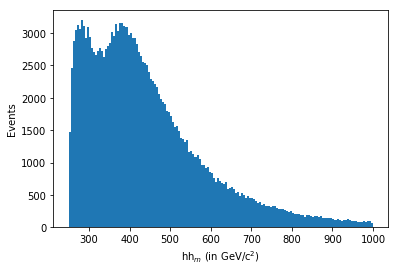

In [120]:
plt.figure(1)
plt.hist(df['hh_m'],range=[250,1000],bins=150)
plt.ylabel("Events")
plt.xlabel("hh$_m$ (in GeV/c$^2$)")
plt.show()
plt.close()

In [121]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

In [122]:
#finding sum, count, mean of each category in weights column
df.groupby('cat')['weight'].agg(['sum','count','mean'])

,sum,count,mean
cat,,,
0,2.971749,148936,0.000020
1,0.159532,8433,0.000019
2,0.152647,8202,0.000019
3,0.051188,2788,0.000018
4,0.013646,750,0.000018
5,0.030381,1523,0.000020
6,0.054648,2868,0.000019
7,0.041555,2245,0.000019
8,0.019401,1077,0.000018


In [123]:
X = df[features]
y = df['cat'] 
w = df['weight']

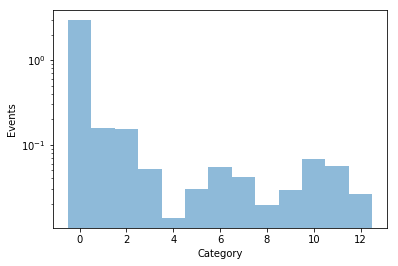

In [124]:
#plotting truth histogram (weighted histogram of categories with logarithmic y scale)
plt.figure(2)
plt.hist(y,weights=w,bins=13,range=[-0.5,12.5],alpha=0.5)
plt.ylabel('Events')
plt.xlabel('Category')
plt.yscale('log')
plt.show()
plt.close()

In [125]:
#function for plotting the graphs
def plotting(y_pred,w_pred,y_truth,w_truth):
    fig=plt.figure(1)
    #plotting predicted histogram
    plt.subplot2grid((5,3),(0,0), rowspan=4,colspan=4)
    plt.hist(y_pred,weights=w_pred,bins=13,range=[-0.5,12.5],alpha=0.5,label='predicted histogram')
    #plotting truth histogram error
    htruth=np.histogram(y_truth,weights=w_truth,bins=13,range=[-0.5,12.5])
    htruth_e=np.histogram(y_truth,weights=w_truth**2,bins=13,range=[-0.5,12.5])
    err_y=np.sqrt(htruth_e[0])
    err_x=np.ones_like(htruth[0])*0.5
    x=np.arange(0,13,step=1)
    plt.errorbar(x,htruth[0],yerr=err_y,xerr=err_x,ecolor='black',elinewidth='0.5',fmt='none',label='error in truth histogram')
    plt.legend()
    plt.ylabel('Events')
    plt.yscale('log')
    #plotting pred/truth plot 
    plt.subplot2grid((5,3),(4,0),rowspan=2,colspan=4)
    hpred=np.histogram(y_pred,weights=w_pred,bins=13,range=[-0.5,12.5])
    ratio=hpred[0]/htruth[0]
    plt.plot(x,ratio,'bo',markersize=2)
    plt.ylim(0.8,1.2)
    #plotting error in pred/truth plot
    hpred_e=np.histogram(y_pred,weights=w_pred**2,bins=13,range=[-0.5,12.5])
    err_y=ratio*np.sqrt((hpred_e[0]/hpred[0])**2+(htruth_e[0]/htruth[0])**2)
    err_x=np.ones_like(x)*0.5
    plt.errorbar(x,ratio,yerr=err_y,xerr=err_x,ecolor='black',elinewidth='0.5',fmt='none')
    plt.ylabel('pred/truth')
    plt.xlabel('Category')
    fig.set_size_inches(7, 9)
    plt.show()
    plt.close()

In [126]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [127]:
#classifier fitted to training set 
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf.joblib') 

CPU times: user 3min 39s, sys: 4.3 s, total: 3min 43s
Wall time: 28 s


['clf.joblib']

In [128]:
#predicting probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
#predicting weight of each data in test set according to category 
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

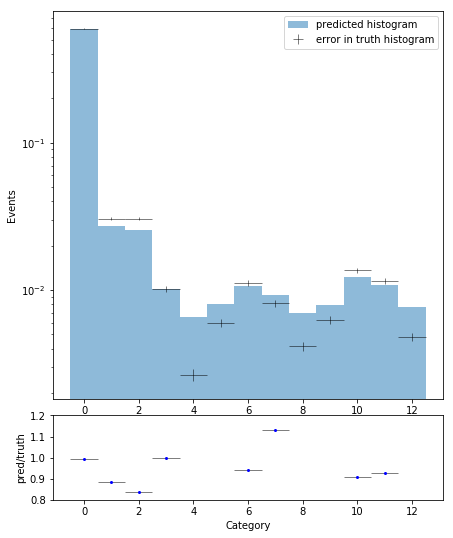

In [129]:
plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [130]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [131]:
#reweighting and clipping it at 50
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,50)
w_train*=rw[y_train]

In [132]:
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_50.joblib') 

CPU times: user 5min 43s, sys: 5.29 s, total: 5min 49s
Wall time: 43.7 s


['clf_50.joblib']

In [133]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

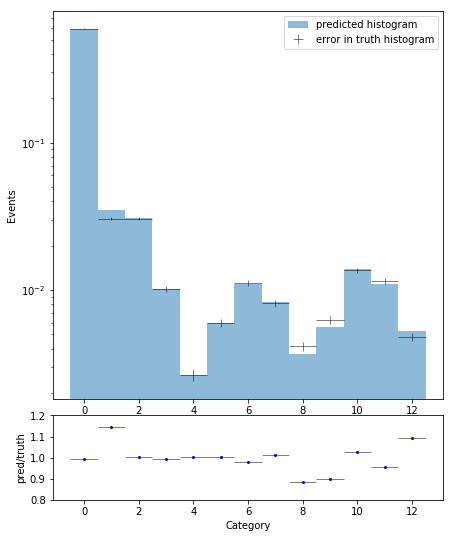

In [134]:
plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [135]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [136]:
#reweighting and clipping it at 25
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,25)
w_train*=rw[y_train]

In [137]:
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_25.joblib') 

CPU times: user 4min 11s, sys: 4.25 s, total: 4min 16s
Wall time: 32.1 s


['clf_25.joblib']

In [138]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

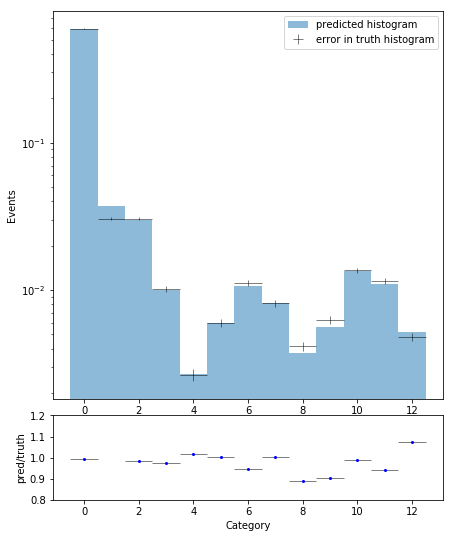

In [139]:
plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [140]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [141]:
#reweighting and clipping it at 10
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,10)
w_train*=rw[y_train]

In [142]:
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_10.joblib') 

CPU times: user 3min 51s, sys: 5.48 s, total: 3min 56s
Wall time: 29.7 s


['clf_10.joblib']

In [143]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

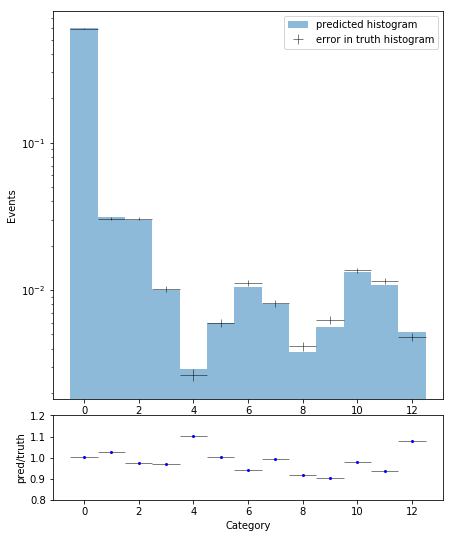

In [144]:
plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [145]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [146]:
#reweighting and clipping it at 75
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,75)
w_train*=rw[y_train]

In [147]:
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_75.joblib') 

CPU times: user 6min 37s, sys: 5.95 s, total: 6min 43s
Wall time: 50.5 s


['clf_75.joblib']

In [148]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

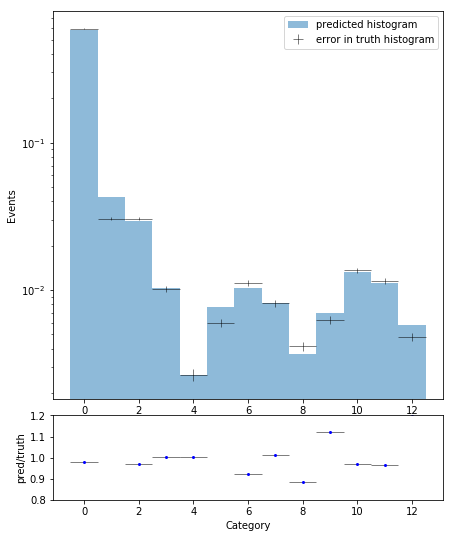

In [149]:
plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [150]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

In [151]:
#reweighting and clipping it at 90
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,90)
w_train*=rw[y_train]

In [152]:
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_90.joblib') 

CPU times: user 6min 51s, sys: 5.32 s, total: 6min 56s
Wall time: 52.1 s


['clf_90.joblib']

In [153]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=y_pred_prob*w_test.reshape(-1,1)
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

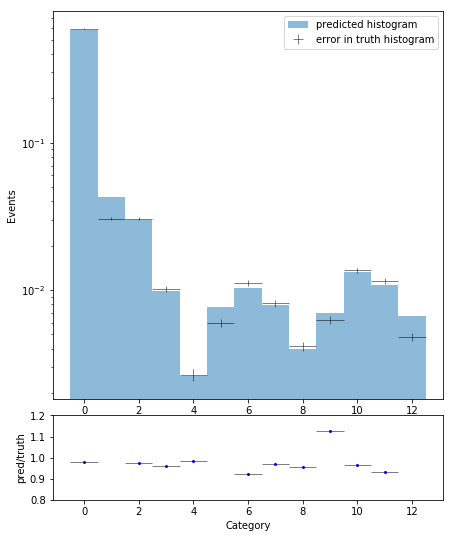

In [154]:
plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)